# Intro
Hello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras. 

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!

In [23]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.exposure import histogram
from skimage.color import rgb2gray, gray2rgb

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img;
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [03:22<00:00,  3.31it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 32.91it/s]


Done!


Let's see if things look all right by drawing some random images and their associated masks.

(256, 256, 3)


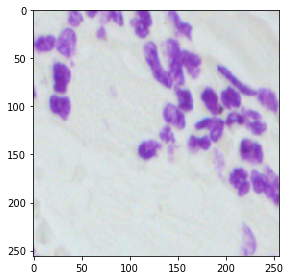

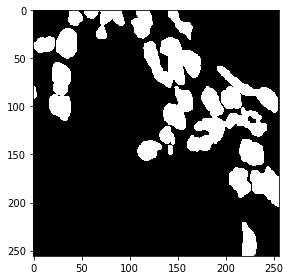

In [8]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
print(X_train[ix].shape)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

Seems good!

# Create our Keras metric

Now we try to define the *mean average precision at different intersection over union (IoU) thresholds* metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. **I'm by no means certain that this implementation is correct, though!** Any assistance in verifying this would be most welcome! 

*Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ... *

def mean_iou(y_pred_batch, y_true_batch):
    return np.mean(np.asarray([pixelAccuracy(y_pred_batch[i], y_true_batch[i]) for i in range(len(y_true_batch))])) 

def pixelAccuracy(y_pred, y_true):
    y_pred = np.argmax(np.reshape(y_pred,[N_CLASSES_PASCAL,img_rows,img_cols]),axis=0)
    y_true = np.argmax(np.reshape(y_true,[N_CLASSES_PASCAL,img_rows,img_cols]),axis=0)
    y_pred = y_pred * (y_true>0)
    
    return 1.0 * np.sum((y_pred==y_true)*(y_true>0)) /  np.sum(y_true>0)

In [5]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [2]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)
c1 = Conv2D(16, (2, 2), activation='elu', kernel_initializer='he_normal', padding='same') (s)
p1 = Conv2D(16, (2, 2), strides = 2, activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c2 = Conv2D(16, (2, 2), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
p2 = Conv2D(32, (2, 2), strides = 2, activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c3 = Conv2D(64, (2, 2), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
p3 = Conv2D(64, (2, 2), strides = 2, activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c4 = Conv2D(64, (2, 2), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
p4 = Conv2D(128, (2, 2), strides = 2, activation='elu', kernel_initializer='he_normal', padding='same') (c4)

#Up
c5 = Conv2D(256, (2, 2), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
u6 = UpSampling2D((2, 2)) (c5)

#print(c1.shape,c2.shape,c3.shape,c4.shape,c5.shape,c6.shape)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = UpSampling2D((2, 2)) (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = UpSampling2D((2, 2)) (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = UpSampling2D((2, 2)) (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

NameError: name 'Input' is not defined

In [26]:
print(c1.shape,c2.shape,c3.shape,c4.shape)
print(c5.shape)
print(c6.shape,c7.shape,c8.shape,c9.shape)

(?, 256, 256, 16) (?, 128, 128, 16) (?, 64, 64, 64) (?, 32, 32, 64)
(?, 16, 16, 256)
(?, 32, 32, 128) (?, 64, 64, 64) (?, 128, 128, 32) (?, 256, 256, 16)


*Update: Changed to ELU units, added dropout.*

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway). I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters. 

*Update: Added early stopping and checkpointing and increased to 30 epochs.*

from sklearn.cross_validation import StratifiedKFold

if __name__ == "__main__":
    n_folds = 10
    data, labels, header_info = load_data()
    skf = StratifiedKFold(labels, n_folds=n_folds, shuffle=True)

    for i, (train, test) in enumerate(skf):
            print("Running Fold", i+1, "/", n_folds)
            model = None # Clearing the NN.
            model = create_model()
            train_and_evaluate_model(model, data[train], labels[train], data[test], labels[test])

In [37]:
# Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-5.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.15, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 569 samples, validate on 101 samples
Epoch 1/50
569/569 [==============================] - 40s 70ms/step - loss: 0.4548 - mean_iou: 0.4118 - val_loss: 0.3294 - val_mean_iou: 0.4300
Epoch 2/50
569/569 [==============================] - 33s 58ms/step - loss: 0.2355 - mean_iou: 0.4522 - val_loss: 0.1498 - val_mean_iou: 0.5007
Epoch 3/50
569/569 [==============================] - 33s 57ms/step - loss: 0.1511 - mean_iou: 0.5466 - val_loss: 0.1438 - val_mean_iou: 0.5788
Epoch 4/50
569/569 [==============================] - 33s 57ms/step - loss: 0.1857 - mean_iou: 0.5930 - val_loss: 0.1434 - val_mean_iou: 0.6078
Epoch 5/50
569/569 [==============================] - 33s 57ms/step - loss: 0.1215 - mean_iou: 0.6231 - val_loss: 0.1135 - val_mean_iou: 0.6402
Epoch 6/50
569/569 [==============================] - 35s 61ms/step - loss: 0.1053 - mean_iou: 0.6529 - val_loss: 0.0927 - val_mean_iou: 0.6664
Epoch 7/50
569/569 [==============================] - 32s 57ms/step - loss: 0.1076 - mean_

569/569 [==============================] - 32s 57ms/step - loss: 0.0988 - mean_iou: 0.7094 - val_loss: 0.0946 - val_mean_iou: 0.7149
Epoch 10/50
569/569 [==============================] - 32s 57ms/step - loss: 0.0937 - mean_iou: 0.7204 - val_loss: 0.0830 - val_mean_iou: 0.7262
Epoch 11/50
569/569 [==============================] - 33s 57ms/step - loss: 0.0860 - mean_iou: 0.7316 - val_loss: 0.0800 - val_mean_iou: 0.7361
Epoch 12/50
569/569 [==============================] - 28s 49ms/step - loss: 0.0855 - mean_iou: 0.7407 - val_loss: 0.0830 - val_mean_iou: 0.7449
Epoch 13/50
569/569 [==============================] - 32s 57ms/step - loss: 0.0824 - mean_iou: 0.7490 - val_loss: 0.0831 - val_mean_iou: 0.7525
Epoch 14/50
569/569 [==============================] - 32s 57ms/step - loss: 0.0874 - mean_iou: 0.7555 - val_loss: 0.0841 - val_mean_iou: 0.7582
Epoch 15/50
569/569 [==============================] - 32s 57ms/step - loss: 0.0844 - mean_iou: 0.7612 - val_loss: 0.0865 - val_mean_iou: 0.76

569/569 [==============================] - 32s 57ms/step - loss: 0.0799 - mean_iou: 0.7706 - val_loss: 0.0758 - val_mean_iou: 0.7730
Epoch 18/50
569/569 [==============================] - 33s 57ms/step - loss: 0.0821 - mean_iou: 0.7749 - val_loss: 0.0808 - val_mean_iou: 0.7769
Epoch 19/50
569/569 [==============================] - 32s 57ms/step - loss: 0.0783 - mean_iou: 0.7789 - val_loss: 0.0745 - val_mean_iou: 0.7808
Epoch 20/50
569/569 [==============================] - 32s 56ms/step - loss: 0.0782 - mean_iou: 0.7826 - val_loss: 0.0717 - val_mean_iou: 0.7843
Epoch 21/50
569/569 [==============================] - 32s 57ms/step - loss: 0.0744 - mean_iou: 0.7861 - val_loss: 0.0730 - val_mean_iou: 0.7877
Epoch 22/50
569/569 [==============================] - 33s 58ms/step - loss: 0.0772 - mean_iou: 0.7892 - val_loss: 0.0759 - val_mean_iou: 0.7908
Epoch 23/50
569/569 [==============================] - 33s 57ms/step - loss: 0.0734 - mean_iou: 0.7921 - val_loss: 0.0699 - val_mean_iou: 0.79

569/569 [==============================] - 32s 57ms/step - loss: 0.0715 - mean_iou: 0.7977 - val_loss: 0.0752 - val_mean_iou: 0.7989
Epoch 26/50
569/569 [==============================] - 33s 57ms/step - loss: 0.0706 - mean_iou: 0.8001 - val_loss: 0.0704 - val_mean_iou: 0.8013
Epoch 27/50
569/569 [==============================] - 33s 57ms/step - loss: 0.0715 - mean_iou: 0.8023 - val_loss: 0.0730 - val_mean_iou: 0.8034
Epoch 28/50
569/569 [==============================] - 33s 57ms/step - loss: 0.0756 - mean_iou: 0.8043 - val_loss: 0.0731 - val_mean_iou: 0.8052
Epoch 29/50
569/569 [==============================] - 33s 59ms/step - loss: 0.0714 - mean_iou: 0.8063 - val_loss: 0.0687 - val_mean_iou: 0.8072
Epoch 30/50
569/569 [==============================] - 33s 57ms/step - loss: 0.0716 - mean_iou: 0.8080 - val_loss: 0.0687 - val_mean_iou: 0.8090
Epoch 31/50
569/569 [==============================] - 33s 58ms/step - loss: 0.0703 - mean_iou: 0.8099 - val_loss: 0.0679 - val_mean_iou: 0.81

569/569 [==============================] - 32s 57ms/step - loss: 0.0677 - mean_iou: 0.8133 - val_loss: 0.0731 - val_mean_iou: 0.8141
Epoch 34/50
569/569 [==============================] - 33s 57ms/step - loss: 0.0672 - mean_iou: 0.8148 - val_loss: 0.0657 - val_mean_iou: 0.8157
Epoch 35/50
569/569 [==============================] - 32s 57ms/step - loss: 0.0674 - mean_iou: 0.8165 - val_loss: 0.0736 - val_mean_iou: 0.8171
Epoch 36/50
569/569 [==============================] - 32s 57ms/step - loss: 0.0665 - mean_iou: 0.8178 - val_loss: 0.0699 - val_mean_iou: 0.8185
Epoch 37/50
569/569 [==============================] - 32s 57ms/step - loss: 0.0665 - mean_iou: 0.8191 - val_loss: 0.0710 - val_mean_iou: 0.8197
Epoch 38/50
569/569 [==============================] - 33s 57ms/step - loss: 0.0660 - mean_iou: 0.8203 - val_loss: 0.0662 - val_mean_iou: 0.8209
Epoch 39/50
569/569 [==============================] - 33s 58ms/step - loss: 0.0644 - mean_iou: 0.8216 - val_loss: 0.0671 - val_mean_iou: 0.82

569/569 [==============================] - 34s 59ms/step - loss: 0.0631 - mean_iou: 0.8240 - val_loss: 0.0650 - val_mean_iou: 0.8247
Epoch 42/50
569/569 [==============================] - 33s 58ms/step - loss: 0.0655 - mean_iou: 0.8252 - val_loss: 0.0671 - val_mean_iou: 0.8258
Epoch 43/50
569/569 [==============================] - 33s 59ms/step - loss: 0.0653 - mean_iou: 0.8263 - val_loss: 0.0695 - val_mean_iou: 0.8269
Epoch 44/50
569/569 [==============================] - 33s 57ms/step - loss: 0.0638 - mean_iou: 0.8274 - val_loss: 0.0693 - val_mean_iou: 0.8279
Epoch 45/50
569/569 [==============================] - 32s 56ms/step - loss: 0.0642 - mean_iou: 0.8284 - val_loss: 0.0645 - val_mean_iou: 0.8289
Epoch 46/50
569/569 [==============================] - 32s 56ms/step - loss: 0.0647 - mean_iou: 0.8294 - val_loss: 0.0675 - val_mean_iou: 0.8299
Epoch 47/50
569/569 [==============================] - 32s 56ms/step - loss: 0.0625 - mean_iou: 0.8304 - val_loss: 0.0695 - val_mean_iou: 0.83

569/569 [==============================] - 32s 56ms/step - loss: 0.0648 - mean_iou: 0.8321 - val_loss: 0.0701 - val_mean_iou: 0.8325
Epoch 50/50
569/569 [==============================] - 32s 57ms/step - loss: 0.0623 - mean_iou: 0.8329 - val_loss: 0.0637 - val_mean_iou: 0.8333


All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [38]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-5.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 1s 12ms/step


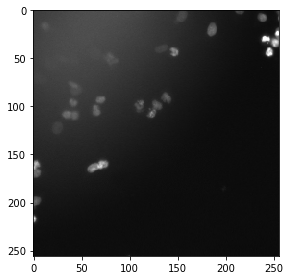

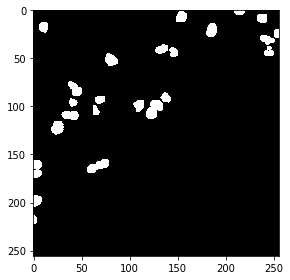

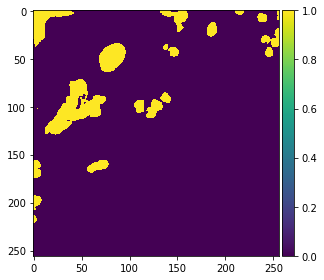

In [39]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

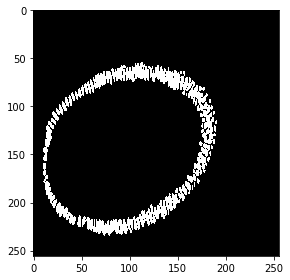

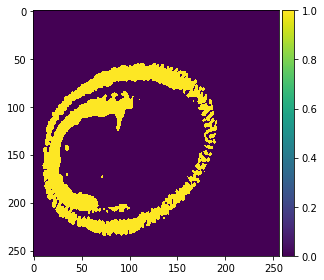

In [40]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
#imshow(X_train[int(X_train.shape[0]*0.9):][ix])
#plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

In [41]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [42]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [45]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('all_conv_unet_3.csv', index=False)

This scored 0.233 on the LB for me. That was with version 2 of this notebook; be aware that the results from the neural network are extremely erratic and vary greatly from run to run (version 3 is significantly worse, for example). Version 7 scores 0.277!

You should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

**Have fun!**

LB score history:
- Version 7: 0.277 LB